# Example 1: Ball drop

To illustrate how to use `emulator` class, we will start with a very simple example of a falling ball. In this example, we emulate the simulation output using only a computer code--a simulator-- data via methods `PCGP` and `PCGPwM`.

First, import the main libraries used for this example.

In [1]:
import numpy as np
import scipy.stats as sps
import sys
import os
import matplotlib.pyplot as plt 
current = os.path.abspath(os.getcwd())
sys.path.append(os.path.normpath(os.path.join(os.path.dirname(current), '..')))
from base.emulation import emulator

## Computer model experiments

In this example, a large ball is dropped from a tower, and its height is recorded at discrete time points until it hits the ground. We will consider two simple models for this physical process. The physics of both models are outlined in \ref{}.

### Model 1 ($M_1$)

The gravitational force causes objects to have the acceleration $g$ downward, so the height $h$ at time $t$ is given by $h = h_0 − \frac{1}{2} gt^2$ where $h_0$ is the initial height and $t$ is the time to hit $h$ (when $t$ is small). To describe the behaviour of falling objects, we use a computer code to simulate an experiment with three inputs:

* time $t$, 
* initial height $h_0$, and 
* gravity $g$.  

Here, $x = (t, h_0)$ represents the controllable input conditions of the experiment, $\theta = g$ is the parameter to be calibrated, and $f(x, \theta)$ represents the computer model outputs.

In [2]:
def balldropmodel_grav(x, theta):
    f = np.zeros((theta.shape[0], x.shape[0]))
    for k in range(0, theta.shape[0]):
        t = x[:, 0]
        h0 = x[:, 1]
        g = theta[k]
        f[k, :] = h0 - (g / 2) * (t ** 2)
    return f.T

### Model 2 ($M_2$)

When the ball is dropped from the top of a tower, its actual velocity approaches the terminal value $v_{ter}$. In that case, when time $t$ is large enough, eventually we can approximate $h$ as a straight line of the form $h = h_0 - v_{ter} t + c$ where $c$ denotes a constant value. To describe the behaviour of falling objects for this case, we use a computer code to simulate an experiment with four inputs:

* time $t$, 
* initial height $h_0$, 
* constant value $c$, and
* terminal velocity $v_{ter}$.

$x = (t, h_0)$ represents the controllable input conditions of the experiment, $\theta = (c, v_{ter})$ are the parameters to be calibrated, and $f(x, \theta)$ represents the computer model outputs.

In [3]:
def balldropmodel_linear(x, theta):
    f = np.zeros((theta.shape[0], x.shape[0]))
    for k in range(0, theta.shape[0]):
        t = x[:, 0]
        h0 = x[:, 1] + theta[k, 0]
        vter = theta[k, 1]
        f[k, :] = h0 - vter * t
    return f.T

Next, we consider the computer model implementation of our mathematical model on an input grid $t \in [0.1, 4.2]$ and $h_0 \in \{25, 50\}$. To do so, we generate the $m \times p$ input matrix $\mathbf{x}$, such that $m$ is the number of input settings and $p$ is the number of controllable inputs. In this example, $m = 84$ and $p = 2$.

In [4]:
# the time vector of interest
tvec = np.concatenate((np.arange(0.1, 4.3, 0.1), np.arange(0.1, 4.3, 0.1))) 

# the drop heights vector of interest
h0vec = np.concatenate((25 * np.ones(42), 50 * np.ones(42)))  

# the input of interest
xtot = (np.vstack((tvec, h0vec)).T).astype('object')  
xtotv = xtot.astype('float')
xtot[xtot[:,1] == 25, 1] = 'lowdrop'
xtot[xtot[:,1] == 50, 1] = 'highdrop'

print(np.shape(xtot))

(84, 2)


## Prior specification

Typically, the researchers have a prior knowledge about the unknown parameters in the form of a prior distribution. 

In $M_1$, we assume

* $g$ is gamma-distributed random variable with shape $\alpha$, location $\mu$ and rate $\beta$ parameters such that $g$ ~$\Gamma(\alpha, \mu, \beta)$ with $\alpha = 2$, $\mu = 0$, $\beta = 5$.

In $M_2$, we assume 

* $v_{ter}$ has a gamma distribution with shape $\alpha$, location $\mu$ and rate $\beta$ parameters such that $v_{ter}$ ~ $\Gamma(\alpha, \mu, \beta)$ with $\alpha = 2$, $\mu = 0$, $\beta = 10$,

* $c$ has a normal distribution with mean $\mu$ and variance $\sigma^2$ such that $c$ ~ $N(\mu, \sigma^2)$ with $\mu = 0$, $\mu = 0$, $\sigma^2 = 5$.

In [5]:
class priorphys_grav:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        if theta.ndim > 1.5:
            return np.squeeze(sps.gamma.logpdf(theta[:, 0], 2, 0, 5))  # gravity
        else:
            return np.squeeze(sps.gamma.logpdf(theta, 2, 0, 5))  # gravity

    def rnd(n):
        return np.reshape(sps.gamma.rvs(2, 0, 5, size=n), (-1,1))  # gravity

In [6]:
class priorphys_lin:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        if theta.ndim > 1.5:
            return np.squeeze(sps.norm.logpdf(theta[:, 0], 0, 5) +  # initial height deviation
                              sps.gamma.logpdf(theta[:, 1], 2, 0, 10))   # terminal velocity
        else:
            return np.squeeze(sps.norm.logpdf(theta[0], 0, 5) +  # initial height deviation
                              sps.gamma.logpdf(theta[1], 2, 0, 10))   # terminal velocity

    def rnd(n):
        return np.vstack((sps.norm.rvs(0, 5, size=n),  # initial height deviation
                          sps.gamma.rvs(2, 0, 10, size=n))).T  # terminal velocity

Note that, in this example, we only use prior distributions to obtain arbitrary setting of parameters, and then to evaluate the computer models at those points to generate $n = 50$ simulation runs. In [Example 2](http://localhost:8888/notebooks/Desktop/GitHub_Folders/ModCal/examples/Example2/Example2_nb.ipynb), we will use them to obtain posterior distribution of calibration parameters $\theta$.

In [7]:
# draw 50 random parameters from the prior
theta_grav = priorphys_grav.rnd(50) 
print(np.shape(theta_grav))

# draw 50 random parameters from the prior
theta_lin = priorphys_lin.rnd(50)  
print(np.shape(theta_lin))

(50, 1)
(50, 2)


Let's evaluate the computer models $M_1$ and $M_2$ at those random points generated above, and obtain $m \times n$ computer model output matrix $\mathbf{f}$.

In [8]:
# create a computer experiment to build an emulator for the gravity simulation
f_grav = balldropmodel_grav(xtotv, theta_grav)  
print(np.shape(f_grav))

# create a computer experiment to build an emulator for the linear simulation
f_lin = balldropmodel_linear(xtotv, theta_lin) 
print(np.shape(f_lin))

(84, 50)
(84, 50)


## Model emulation

In this section, our goal is to illustrate how to predict, or $emulate$ our computer models, e.g., $M_1$ and $M_2$. 

To do this, we use two different methods `PCGP` and `PCGPwM`. First, we build an emulator for the linear simulation:

In [9]:
# build an emulator for the linear simulation
emu_lin_1 = emulator(x = xtot, theta = theta_lin, f = f_lin, method = 'PCGP_ozge') 

Function supplementtheta not found in module!
PCGP_ozge considering  2 PCs


In [10]:
# build an emulator for the linear simulation
emu_lin_2 = emulator(x = xtot, theta = theta_lin, f = f_lin, method = 'PCGPwM') 

PCGPwM considering  2 PCs


Build an emulator for the gravity simulation:

In [11]:
# build an emulator for the gravity simulation
emu_grav_1 = emulator(x = xtot, theta = theta_grav, f = f_grav, method = 'PCGP_ozge')

Function supplementtheta not found in module!
PCGP_ozge considering  2 PCs


In [12]:
# build an emulator for the gravity simulation
emu_grav_2 = emulator(x = xtot, theta = theta_grav, f = f_grav, method = 'PCGPwM')  

PCGPwM considering  1 PCs


## Comparison of emulation methodologies

One way to test the accuracy of the emulators is to create a hold-out simulation run, and compare the predicted values from the emulator and simulated values. To do this, let's first generate random draws of parameters, and evaluate the computer model at those values.

In [13]:
# (Test) draw 50 random parameters from the prior
theta_grav_test = priorphys_grav.rnd(50) 

# (Test) draw 50 random parameters from the prior
theta_lin_test = priorphys_lin.rnd(50)  

# (Test) the value of the gravity simulation
f_grav_test = balldropmodel_grav(xtotv, theta_grav_test)  

# (Test) the value of the linear simulation
f_lin_test = balldropmodel_linear(xtotv, theta_lin_test) 

Then, let's get the `predict` object of the `emulator` for the hold-out data:

In [14]:
pred_grav_1 = emu_grav_1.predict(x = xtot, theta = theta_grav_test)
pred_grav_2 = emu_grav_2.predict(x = xtot, theta = theta_grav_test)

pred_lin_1 = emu_lin_1.predict(x = xtot, theta = theta_lin_test)
pred_lin_2 = emu_lin_2.predict(x = xtot, theta = theta_lin_test)

In [15]:
# get the prediction means and variances
pred_lin_1_m, pred_lin_1_var  = pred_lin_1.mean(), pred_lin_1.var()
pred_lin_2_m, pred_lin_2_var = pred_lin_2.mean(), pred_lin_2.var()
pred_grav_1_m, pred_grav_1_var = pred_grav_1.mean(), pred_grav_1.var()
pred_grav_2_m, pred_grav_2_var = pred_grav_2.mean(), pred_grav_2.var()

In [16]:
def plot_residuals(f, pred_mean, pred_var):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    t1 = (pred_mean - f)/np.sqrt(pred_var)
    p1_ub = np.percentile(t1, 97.5, axis = 1)
    p1_lb = np.percentile(t1, 2.5, axis = 1)
    axs[0].fill_between(range(42), p1_lb[0:42], p1_ub[0:42], color = 'grey', alpha=0.25)
    axs[0].hlines(0, 0, 42, linestyles = 'dashed', colors = 'black')
    axs[1].fill_between(range(42), p1_lb[42:84], p1_ub[42:84], color = 'grey', alpha=0.25)
    axs[1].hlines(0, 0, 42, linestyles = 'dashed', colors = 'black')
    plt.show()

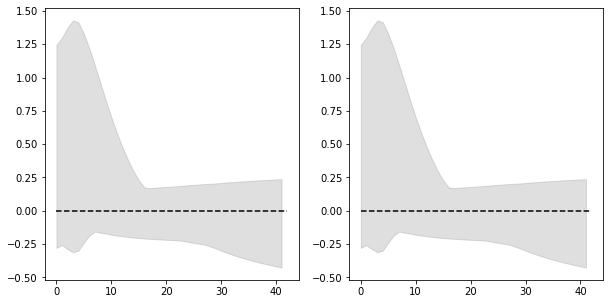

In [17]:
plot_residuals(f = f_lin_test, pred_mean = pred_lin_1_m, pred_var = pred_lin_1_var)

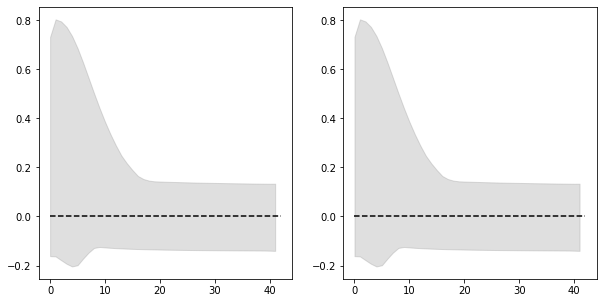

In [18]:
plot_residuals(f = f_lin_test, pred_mean = pred_lin_2_m, pred_var = pred_lin_2_var)

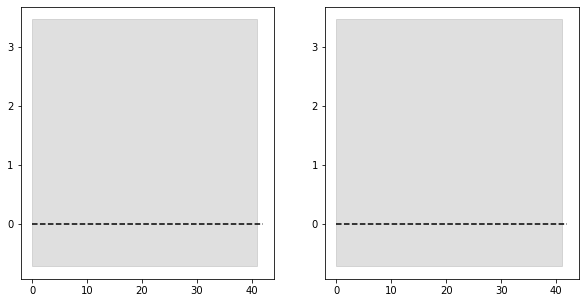

In [19]:
plot_residuals(f = f_grav_test, pred_mean = pred_grav_1_m, pred_var = pred_grav_1_var)

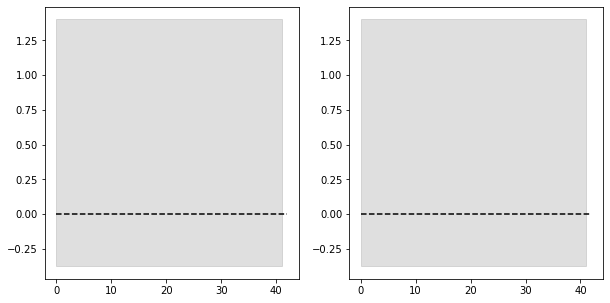

In [20]:
plot_residuals(f = f_grav_test, pred_mean = pred_grav_2_m, pred_var = pred_grav_2_var)

Finally, let's observe the sum of squared deviations between the prediction means and the simulated output:

In [21]:
print('Rsq PCGP = ', 1 - np.sum(np.square(pred_lin_1_m - f_lin_test))/np.sum(np.square(f_lin_test.T - np.mean(f_lin_test, axis = 1))))
print('Rsq PCGPwM = ', 1 - np.sum(np.square(pred_lin_2_m - f_lin_test))/np.sum(np.square(f_lin_test.T - np.mean(f_lin_test, axis = 1))))

print('SSE PCGP = ', np.sum(np.square(pred_lin_1_m - f_lin_test)))
print('SSE PCGPwM = ', np.sum(np.square(pred_lin_2_m - f_lin_test)))

print('Rsq PCGP = ', 1 - np.sum(np.square(pred_grav_1_m - f_grav_test))/np.sum(np.square(f_grav_test.T - np.mean(f_grav_test, axis = 1))))
print('Rsq PCGPwM = ', 1 - np.sum(np.square(pred_grav_2_m - f_grav_test))/np.sum(np.square(f_grav_test.T - np.mean(f_grav_test, axis = 1))))

print('SSE PCGP = ', np.sum(np.square(pred_grav_1_m - f_grav_test)))
print('SSE PCGPwM = ', np.sum(np.square(pred_grav_2_m - f_grav_test)))

Rsq PCGP =  0.9990344786038264
Rsq PCGPwM =  0.9998857717381361
SSE PCGP =  4466.570327722193
SSE PCGPwM =  528.428025573032
Rsq PCGP =  0.9868184502501229
Rsq PCGPwM =  0.9997771391824493
SSE PCGP =  66431.93469626541
SSE PCGPwM =  1123.1665137115497
